In [67]:
library("DESeq2")
library("ggplot2")
library("ggrepel")
library("ggcorrplot")
library("dplyr")
library(stringr)
library(purrr)
library("tibble")
library(dplyr)
library(tidyr)
library(ComplexHeatmap)
library("pals")
library(ggpubr)
library(tximport)
library(DESeq2)
library("apeglm")
theme_set(
    theme_classic(base_size = 12)
)

In [82]:
source('./plot_data.R')

In [133]:
txi<- readRDS("../data/1_total_rna_rsem_gene_txi.obj")
final_iso_tb<- read.table('../data/2_final_iso_tb.tsv', header = T, row.names = 1, sep = '\t')
filter = rownames(txi$abundance) %in% final_iso_tb$gene_id
txi$abundance <- txi$abundance[filter, ]
txi$counts <- txi$counts[filter, ]
txi$length <- txi$length[filter, ]
print(dim(txi$counts))

[1] 6016    6


In [134]:
# column meta
coldata <- data.frame('condition' = c(rep('MUT', 3), rep('WT', 3)), 'replicate' = rep(c('rep1', 'rep2', 'rep3'), 2))
rownames(coldata) = colnames(txi$abundance)
coldata$condition<- factor(coldata$condition, levels = c('WT', 'MUT'))

dds <- DESeqDataSetFromTximport(txi, colData = coldata, design = ~ condition)

dim(counts(dds))
# 6016 genes
# gene has to have at least 3 counts (inclusive) in minumum of 5 samples (inclusive)
smallestGroupSize <- 5
filter <- rowSums(counts(dds) <= 3) >= smallestGroupSize
dds <- dds[!filter,]
dim(counts(dds))

# 5544 genes
# 8% got filterd out

using counts and average transcript lengths from tximport



[1] 6016    6

[1] 5544    6

In [135]:
dds <- DESeq(dds)
resultsNames(dds)
res <- results(dds, name="condition_MUT_vs_WT")
res_shrink_lfc <- lfcShrink(dds, coef="condition_MUT_vs_WT", type="apeglm")

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"           "condition_MUT_vs_WT"

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



In [136]:
deseq2_df<- analyzeDESeq_gene(res, res_shrink_lfc, padj_cutoff = 1e-3, log2fc_cutoff = 0.5, annot_down = 2, annot_up = 2)
# gene classification
deseq2_df$class= final_iso_tb[match(rownames(deseq2_df), final_iso_tb$gene_id), "class"]
deseq2_df$class<- factor(deseq2_df$class, levels = c('low', 'medium', 'high'))

write.table(x = deseq2_df, file = '../data/3_total_rna_deseq2_results.tsv', quote = F, sep = '\t', col.names = T, row.names = T)

## plot differentially expressed genes

In [137]:
mcol <- c("#80b1d3", "#fb8072", "grey")
names(mcol) <- c("Down in MUT", "Up in MUT", "Not sig")
# adjust outliers
deseq2_df[deseq2_df$padj<10e-200, 'padj'] = 10e-200

In [138]:
deseq2_df %>% count(labels)

labels,n
<fct>,<int>
Not sig,4858
Down in MUT,178
Up in MUT,508


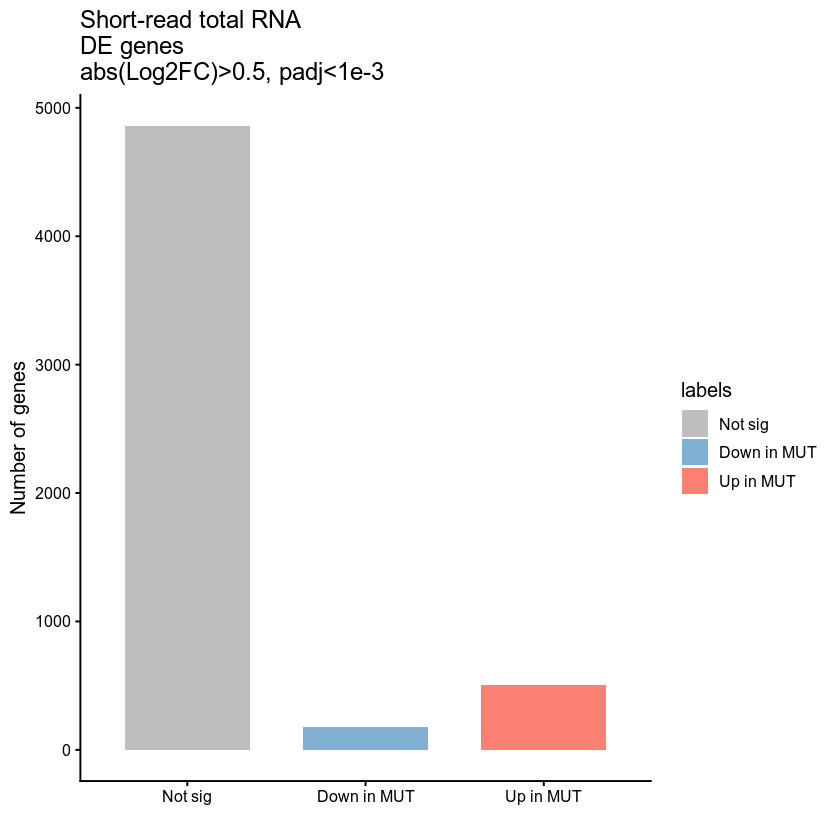

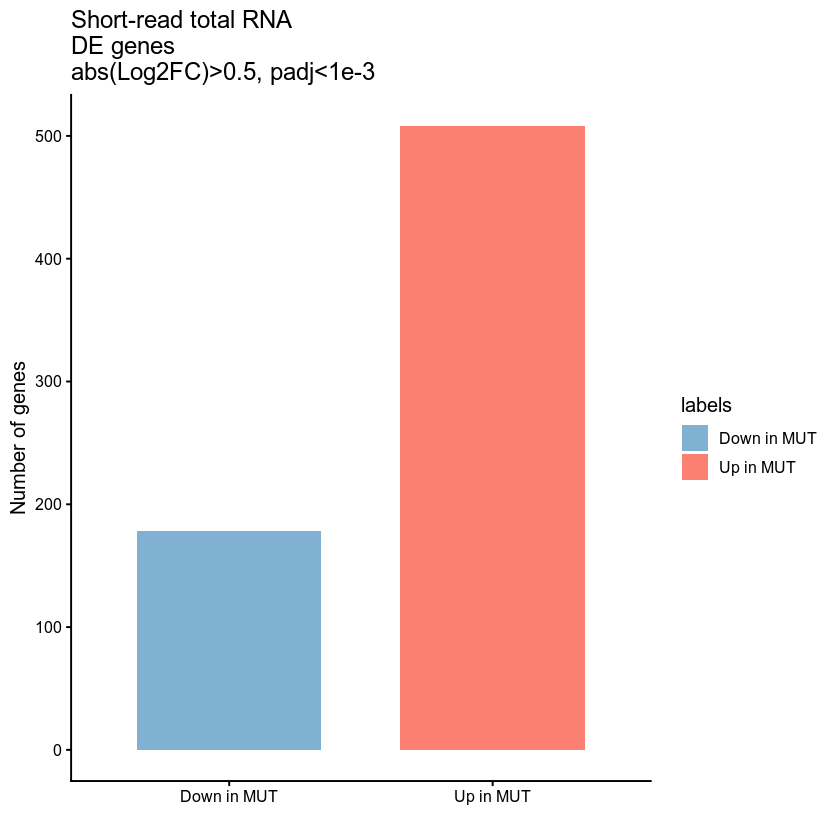

In [139]:
deseq2_df %>% 
    ggplot(aes(x=factor(labels), fill=labels)) +
    geom_bar(stat='count', width=0.7) +
    labs(x = '', y = 'Number of genes', title = 'Short-read total RNA\nDE genes\nabs(Log2FC)>0.5, padj<1e-3') +
    scale_fill_manual(values = mcol)

ggsave('../figures/Supp_total_rna_gene_deseq2_barplot.pdf', width = 6, height = 3)


deseq2_df %>% filter(labels!= 'Not sig') %>% 
    ggplot(aes(x=factor(labels), fill=labels)) +
    geom_bar(stat='count', width=0.7) +
    labs(x = '', y = 'Number of genes', title = 'Short-read total RNA\nDE genes\nabs(Log2FC)>0.5, padj<1e-3') +
    scale_fill_manual(values = mcol)

ggsave('../figures/Supp_total_rna_gene_deseq2_barplot_sig.pdf', width = 4, height = 3)

Warning message:
“Removed 5540 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 5540 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


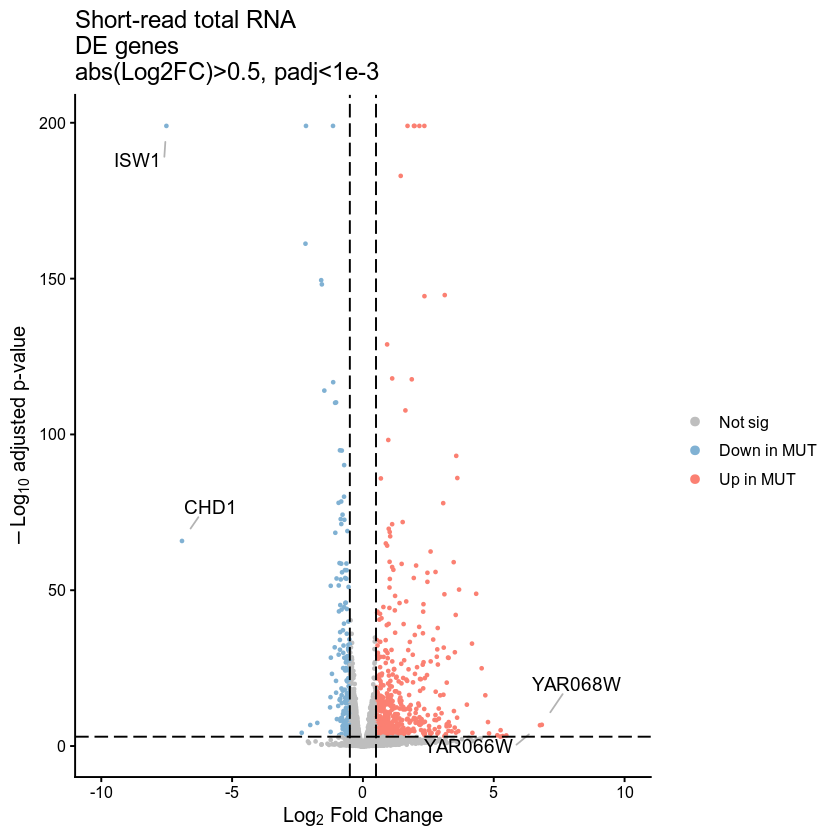

In [140]:
p <- deseq2_df %>%
    ggplot(aes(x = log2FoldChange, y = -log10(padj), label = annotation)) +
    geom_point(aes(col = labels), size = 0.6) +
    geom_text_repel(box.padding = 1, point.padding = 1, max.overlaps = 5, size = 4, segment.color = "grey70") +
    labs(x = expression(Log[2] * " Fold Change"),y = expression(-Log[10] * " adjusted p-value"), 
         title = 'Short-read total RNA\nDE genes\nabs(Log2FC)>0.5, padj<1e-3', col = "") +
    scale_color_manual(values = mcol) +
    geom_hline(yintercept = -log10(1e-3), color = 'black', linetype = "longdash") +
    geom_vline(xintercept = 0.5, color = 'black', linetype = "longdash") +
    geom_vline(xintercept = -0.5, color = 'black', linetype = "longdash") +
    guides(color = guide_legend(override.aes = list(size = 2))) +
    xlim(-10, 10)
p
ggsave('../figures/Supp_total_rna_gene_deseq2_volcano.pdf', width = 5, height = 3)

low             medium               high 
    "low\nn = 942" "medium\nn = 3449"   "high\nn = 1153"

Joining with `by = join_by(class)`


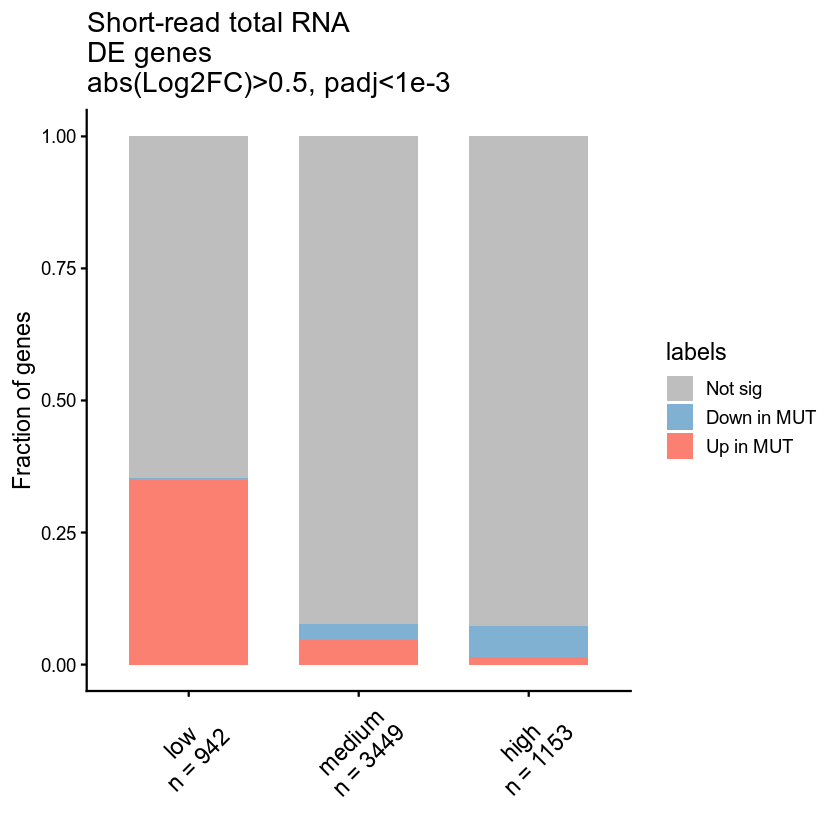

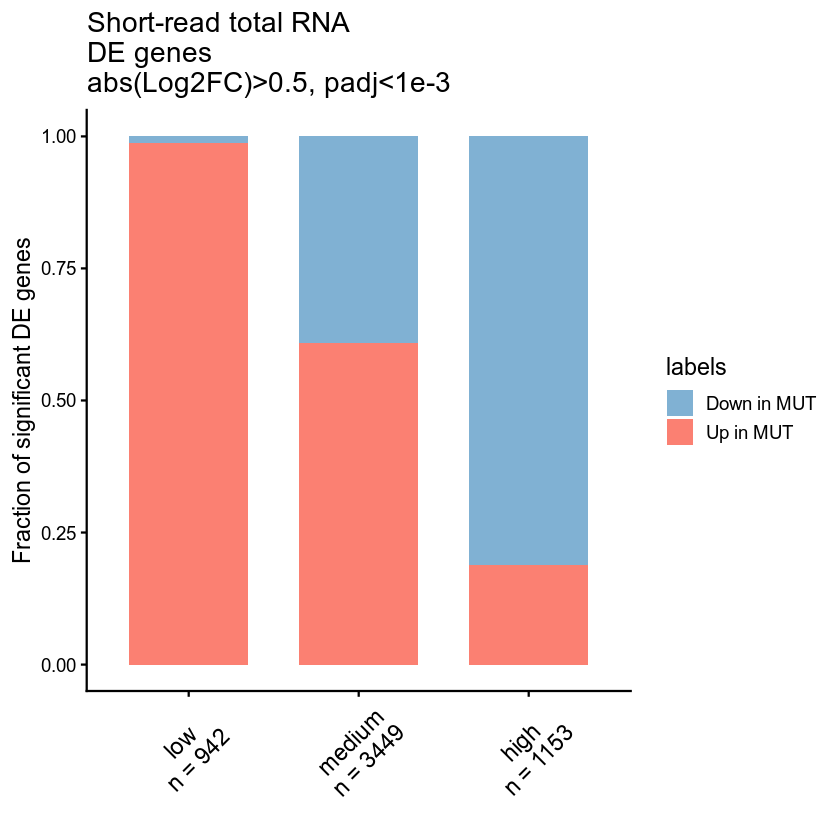

In [143]:
df<- deseq2_df %>% count(class)
x_label<- paste0(df$class, "\nn = ", df$n)
names(x_label)<- df$class
x_label

df<- deseq2_df %>% count(labels, class) %>% 
    left_join(deseq2_df %>% count(class, name = "total")) %>% 
    mutate(percentage = round(n/total, 3)) %>% arrange(class, labels)

write.table(df %>% select(class, labels, n, percentage), '../data/3_total_rna_deseq2_number_of_genes_by_expression.tsv', quote = F, sep = '\t', col.names = T, row.names = F)

deseq2_df %>% 
    ggplot(aes(x=factor(class), fill=labels)) +
    geom_bar(stat='count', position = "fill", width=0.7) +
    theme_classic(base_size = 14) +
    labs(x = '', y = 'Fraction of genes', title = 'Short-read total RNA\nDE genes\nabs(Log2FC)>0.5, padj<1e-3') +
    scale_fill_manual(values = mcol) +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5, size = 14)) +
    scale_x_discrete(labels = x_label)

ggsave('../figures/Supp_total_rna_gene_deseq2_barplot_by_gene_expresson.pdf', width = 5, height = 4)


deseq2_df %>% 
    filter(labels!= 'Not sig') %>% 
    ggplot(aes(x=factor(class), fill=labels)) +
    geom_bar(stat='count', position = "fill", width=0.7) +
    theme_classic(base_size = 14) +
    labs(x = '', y = 'Fraction of significant DE genes', title = 'Short-read total RNA\nDE genes\nabs(Log2FC)>0.5, padj<1e-3') +
    scale_fill_manual(values = mcol) +
    theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5, size = 14)) +
    scale_x_discrete(labels = x_label)

ggsave('../figures/Supp_total_rna_gene_deseq2_barplot_by_gene_expresson_sig.pdf', width = 5, height = 4)

In [142]:
df %>% select(class, labels, n, percentage)

class,labels,n,percentage
<fct>,<fct>,<int>,<dbl>
low,Not sig,609,0.646
low,Down in MUT,4,0.004
low,Up in MUT,329,0.349
medium,Not sig,3181,0.922
medium,Down in MUT,105,0.030
medium,Up in MUT,163,0.047
high,Not sig,1068,0.926
high,Down in MUT,69,0.060
high,Up in MUT,16,0.014
